## Loading the dataset and training an image classifier

In [93]:
import os
import pandas as pd
import numpy as np
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [94]:
import torch.optim as optim
from torch import nn

In [95]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [96]:
# Defining the paths

# path_data = os.path.join(os.path.dirname(os.getcwd()),"Data")
path_images = "D:\\Study\\Conda Projects\\Polyp Detection\\TrainingSet_NewGT\\train_1k"
path_images

'D:\\Study\\Conda Projects\\Polyp Detection\\TrainingSet_NewGT\\train_1k'

In [97]:
path_labels = "D:\\Study\\Conda Projects\\Polyp Detection\\TrainingSet_NewGT\\annotations_polyp.csv"
path_labels

'D:\\Study\\Conda Projects\\Polyp Detection\\TrainingSet_NewGT\\annotations_polyp.csv'

In [98]:
# path_test_labels = os.path.join(path_data,"annotations_test.csv")
# path_test_labels

### Loading the dataset using custom loader

In [99]:
# Loading the dataset

class polypDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.to_list()
        
        img_name = os.path.join(self.root_dir,self.labels.iloc[index,0])
        img_name = img_name +".png"
        image = cv2.imread(img_name)
        label = self.labels.iloc[index,1]

        if self.transform:
            image = self.transform(image)
        
        return image,label

In [100]:
# Defining the transform

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224))
])

In [101]:
# Creating the dataset
dataset_cd = polypDataset(csv_file=path_labels, root_dir=path_images, transform=transform)
dataloader_cd = DataLoader(dataset_cd, batch_size=32, shuffle=True)

In [102]:
# dataset_test = dogCatDataset(csv_file=path_test_labels, root_dir=path_images, transform=transform)
# dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)

In [103]:
len(dataset_cd)

2979

In [104]:
for i, sample in enumerate(dataset_cd):
    print(i, sample[0].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224])
1 torch.Size([3, 224, 224])
2 torch.Size([3, 224, 224])
3 torch.Size([3, 224, 224])


### Building the neural network

In [105]:
from torchvision.models import resnet50

In [106]:
model = resnet50(pretrained=True)

d:\Study\Conda Projects\opdl\opdl\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Study\Conda Projects\opdl\opdl\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [107]:
# Changing the final layer based on the number of classes
model.fc = nn.Linear(model.fc.in_features,1)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [108]:
# Specity the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [109]:
from tqdm import tqdm

In [110]:
model.train()
num_epochs = 10
for epoch in range(num_epochs):   
    running_loss = 0.0
    correct_predictions = 0.0
    total_samples = 0.0
    for images, labels in tqdm(dataloader_cd):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        labels = labels.unsqueeze(1)
        labels = labels.float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
        correct_predictions += (predicted_labels == labels).sum().item()
        total_samples+=labels.size(0)
    # auc_score = running_auc/len(dataset_cd)
    epoch_loss = running_loss / len(dataset_cd)
    accuracy = correct_predictions / total_samples
    print('Epoch [{}/{}],Accuracy:{:.4f}, Loss: {:.4f}'.format(epoch+1, num_epochs,accuracy, epoch_loss))

  0%|          | 0/94 [00:00<?, ?it/s]

100%|██████████| 94/94 [02:17<00:00,  1.47s/it]


Epoch [1/10],Accuracy:0.9933, Loss: 0.0220


100%|██████████| 94/94 [01:46<00:00,  1.14s/it]


Epoch [2/10],Accuracy:1.0000, Loss: 0.0013


100%|██████████| 94/94 [02:45<00:00,  1.76s/it]


Epoch [3/10],Accuracy:0.9997, Loss: 0.0020


100%|██████████| 94/94 [02:57<00:00,  1.88s/it]


Epoch [4/10],Accuracy:1.0000, Loss: 0.0024


100%|██████████| 94/94 [03:05<00:00,  1.97s/it]


Epoch [5/10],Accuracy:1.0000, Loss: 0.0004


100%|██████████| 94/94 [03:16<00:00,  2.09s/it]


Epoch [6/10],Accuracy:0.9997, Loss: 0.0009


100%|██████████| 94/94 [03:24<00:00,  2.17s/it]


Epoch [7/10],Accuracy:1.0000, Loss: 0.0018


100%|██████████| 94/94 [03:29<00:00,  2.23s/it]


Epoch [8/10],Accuracy:1.0000, Loss: 0.0003


100%|██████████| 94/94 [03:32<00:00,  2.26s/it]


Epoch [9/10],Accuracy:1.0000, Loss: 0.0002


100%|██████████| 94/94 [03:30<00:00,  2.24s/it]

Epoch [10/10],Accuracy:0.9997, Loss: 0.0025


In [ ]:
# # Using the model for inference

# model = model.eval()
# losses = []
# correct_predictions = 0
# with torch.no_grad():
#     for inputs, labels in tqdm(dataloader_test):
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         outputs = model(inputs)
#         labels -= 1
#         labels = labels.unsqueeze(1)
#         labels = labels.float()
#         loss = criterion(outputs, labels)
#         # correct_predictions += torch.sum(outputs == labels)
#         losses.append(loss.item())
#         predicted_labels = (torch.sigmoid(outputs) > 0.5).squeeze(1).long()
#         correct_predictions += (predicted_labels == labels).sum().item()
# print(correct_predictions / len(dataset_test), np.mean(losses))

In [109]:
print(correct_predictions)
print(len(dataset_test))

67843
3669


### Inferencing one image

In [117]:
path_test_image = os.path.join(path_images,"pomeranian_3.jpg")
# path_test_image = os.path.join(path_images,"Bombay_74.jpg")
test_image = cv2.imread(path_test_image)
test_image = transform(test_image)

In [118]:
model.eval()
test_image = test_image.unsqueeze(0)
test_image = test_image.to(device)
test_image.size()

torch.Size([1, 3, 224, 224])

In [119]:
output_test = model(test_image)
predicted_label_test = (torch.sigmoid(output_test) > 0.5).squeeze(1).long()

In [120]:
predicted_label_test

tensor([1], device='cuda:0')

### Saving the model weights

In [111]:
torch.save(model.state_dict(),os.path.join(os.path.dirname(os.getcwd()),"checkpoints\\model_polyp_resnet50_epochs10.pth"))

### Grad-CAM 

In [112]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [113]:
import matplotlib.pyplot as plt

In [114]:
target_layers = [model.layer4[-1]]

In [115]:
cam = GradCAM(model=model, target_layers=target_layers)

In [116]:
path_test_image = "D:\\Study\\Conda Projects\\Polyp Detection\\TrainingSet_NewGT\\train_1k\\ShortVD_wp_4_frame_158_GT.png"
test_image = cv2.imread(path_test_image)
test_image = transform(test_image)
test_image = test_image.unsqueeze(0)
test_image = test_image.to(device)

In [66]:
grayscale_cam = cam(input_tensor=test_image,eigen_smooth=True,aug_smooth=True)

In [89]:
grayscale_cam_img = grayscale_cam[0, :]
grayscale_cam_img = np.where(grayscale_cam_img>0.58,255,0)
np.max(grayscale_cam_img)

255

In [87]:
len(np.unique(grayscale_cam_img))

2

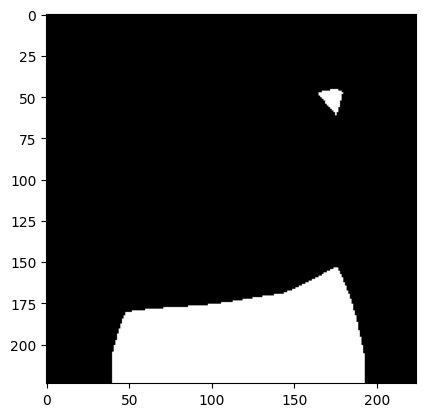

In [117]:
plt.imshow(grayscale_cam_img,cmap='gray')
plt.show()

In [70]:
test_image_cam = cv2.imread(path_test_image)
test_image_cam = cv2.resize(test_image_cam,(224,224))
test_image_cam = (test_image_cam/255).astype(np.uint8)
test_image_cam.dtype

dtype('uint8')

In [71]:
from PIL import Image

In [73]:
visualization = show_cam_on_image(test_image_cam, grayscale_cam, use_rgb=True)
Image.fromarray(visualization)

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\colormap.cpp:736: error: (-5:Bad argument) cv::ColorMap only supports source images of type CV_8UC1 or CV_8UC3 in function 'cv::colormap::ColorMap::operator ()'
